## Definitions

In [1]:
#matplotlib inline
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adadelta, Adam, SGD
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Add, Input, GlobalAveragePooling2D, Activation, Concatenate
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from google.colab import drive
#drive.mount("/content/gdrive", force_remount=True)
#os.chdir("/content/gdrive/My Drive/Colab Notebooks") # might have to change path to point to your Colab Notebooks folder

## Load and format data

Number of classes: 10
Example of handwritten digit with correlated noise: 



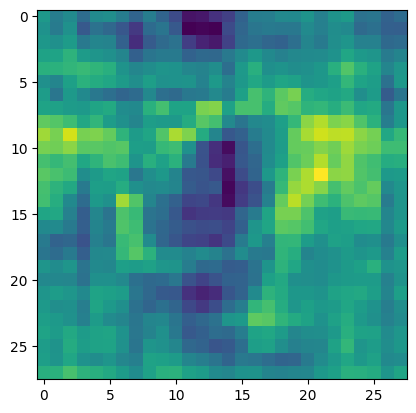

Class: 9

Shape of x_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)


In [2]:
data = np.load('./MNIST_CorrNoise.npz')

x_train = data['x_train']
y_train = data['y_train']

num_cls = len(np.unique(y_train))
print('Number of classes: ' + str(num_cls))

print('Example of handwritten digit with correlated noise: \n')

k = 3000
plt.imshow(np.squeeze(x_train[k,:,:]))
plt.show()
print('Class: '+str(y_train[k])+'\n')

# RESHAPE and standarize
x_train = np.expand_dims(x_train/255,axis=3)

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_cls)

print('Shape of x_train: '+str(x_train.shape))
print('Shape of y_train: '+str(y_train.shape))

## Training

In [3]:
model_name='CNN_personal' # To compare models, you can give them different names

pweight='./weights/weights_' + model_name  + '.keras'

if not os.path.exists('./weights'):
  os.mkdir('./weights')

## EXPLORE VALUES AND FIND A GOOD SET
b_size = 5 # batch size
val_split = 0.2 # percentage of samples used for validation (e.g. 0.5)
ep = 30 # number of epochs

## Personalized NN

/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,930 (616.91 KB)

 Trainable params: 157,290 (614.41 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/30
9599/9600 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4765 - loss: 1.4871
Epoch 1: val_loss improved from inf to 0.42450, saving model to ./weights/weights_CNN_personal.keras
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 95s 10ms/step - accuracy: 0.4765 - loss: 1.4870 - val_accuracy: 0.8583 - val_loss: 0.4245
Epoch 2/30
9599/9600 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8027 - loss: 0.6229
Epoch 2: val_loss improved from 0.42450 to 0.33030, saving model to ./weights/weights_CNN_personal.keras
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 101s 11ms/step - accuracy: 0.8027 - loss: 0.6229 - val_accuracy: 0.8903 - val_loss: 0.3303
Epoch 3/30
9597/9600 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8372 - loss: 0.5121
Epoch 3: val_loss improved from 0.33030 to 0.28864, saving model to ./weights/weights_CNN_personal.keras
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 105s 11ms/step - accuracy: 0.8372 - loss: 0.5121 - val_accuracy: 0.9051 - val_loss: 0.2886
Epoch 4/30
9599/9600 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - a

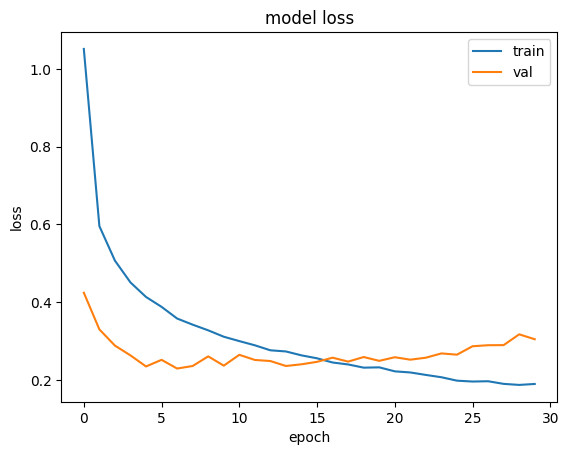

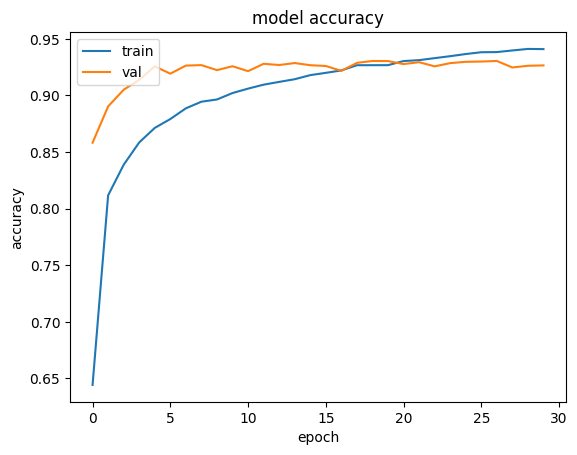

In [4]:
# Input Layer
input_layer = Input(shape=(28, 28, 1))

# Define the model
model = Sequential()

# Input Layer + First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(10, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

checkpointer = ModelCheckpoint(filepath=pweight, verbose=1, save_best_only=True)
callbacks_list = [checkpointer]

history = model.fit(x_train, y_train,
                    epochs=ep,
                    batch_size=b_size,
                    verbose=1,
                    shuffle=True,
                    validation_split=val_split,
                    callbacks=callbacks_list)

print('CNN_1 weights saved in ' + pweight)

# Plot loss vs epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Make predictions in test set

In [5]:
from keras.models import load_model

## LOAD DATA
data = np.load('./MNIST_CorrNoise.npz')

x_test = data['x_test']
y_test = data['y_test']

num_cls = len(np.unique(y_test))
print('Number of classes: ' + str(num_cls))

# RESHAPE and standarize
x_test = np.expand_dims(x_test/255,axis=3)

print('Shape of x_train: '+str(x_test.shape)+'\n')

model = load_model(pweight)
y_pred = model.predict(x_test)
# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure y_test is also in class indices (not one-hot encoded)
if len(y_test.shape) > 1:  # If y_test is one-hot encoded
    y_test = np.argmax(y_test, axis=1)

Acc_pred = sum(y_pred_classes == y_test) / len(y_test)
#Acc_pred = sum(y_pred == y_test)/len(y_test)

print('Accuracy in test set is: '+str(Acc_pred))


Number of classes: 10
Shape of x_train: (10000, 28, 28, 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy in test set is: 0.9226
